# HW09

## Exercises to practice unsupervised learning, clustering and PCA

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/HW08/raw/main/HW08_utils.pyc

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering, SpectralClustering

from data_utils import PCA, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02) and then again in [HW08](https://github.com/DM-GY-9103-2024F-H/HW08) last week.

This is the dataset that has anthropometric information about U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [4]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [5]:
## Encode non-numerical features
ansur_encoder = OrdinalEncoder()
g_vals = ansur_encoder.fit_transform(ansur_df[["gender"]].values)
ansur_df[["gender"]] = g_vals

## Normalize the data
ansur_scaler = StandardScaler()
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)


In [6]:
## Separate the features we want to consider
ansur_features = ansur_scaled_df[["head.height", "head.circumference", "ear.length", "ear.breadth", "ear.protrusion"]]

KMeans distance error: 1.5650217475521446
KMeans likelihood error: -5.499901411481705
KMeans balance error: 0.03142857142857143


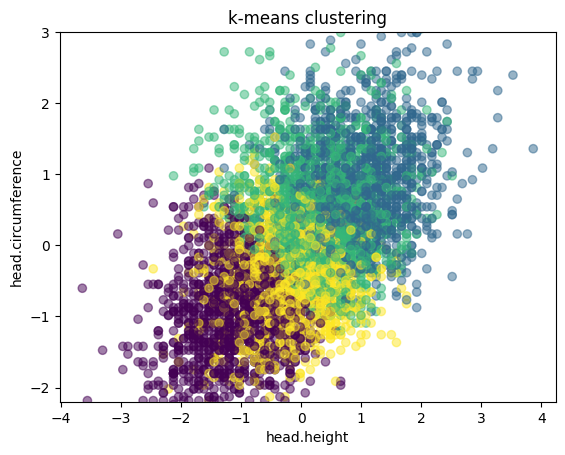

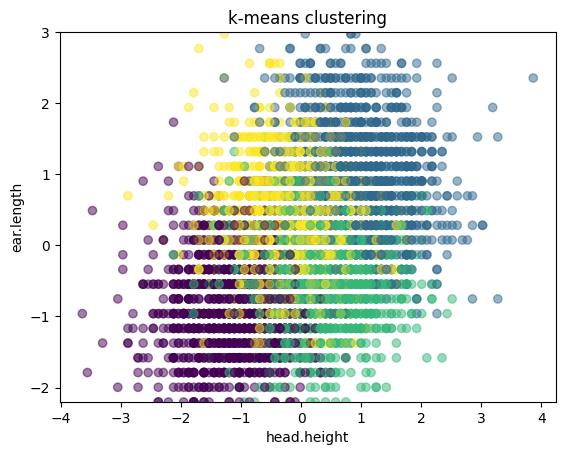

In [7]:
## Create Clustering model
n_clusters = 4
km_model = KMeansClustering(n_clusters=n_clusters)

## Run the model(s) on the data
km_predicted = km_model.fit_predict(ansur_features)

## Check errors
print("KMeans distance error:", km_model.distance_error())
print("KMeans likelihood error:", km_model.likelihood_error())
print("KMeans balance error:", km_model.balance_error())

## Plot clusters as function of 2 or 3 variables
ansur_features.cov()

xl, yl, zl = "head.height", "head.circumference", "ear.length"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

clusters = km_predicted["clusters"]

# 2D
plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

plt.show()

Spectral distance error: 1.5778776761345688
Spectral likelihood error: -5.508237840348101
Spectral balance error: 0.15238095238095237


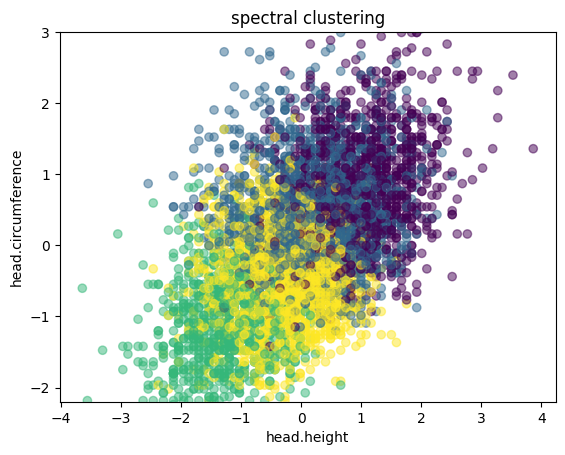

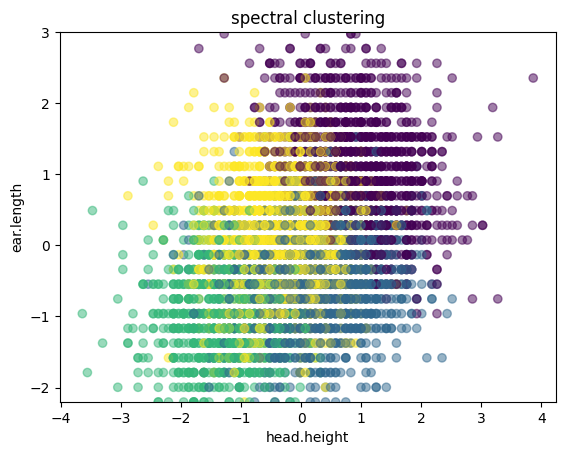

In [8]:
n_clusters = 4
sc_model = SpectralClustering(n_clusters=n_clusters)

sc_predicted = sc_model.fit_predict(ansur_features)

print("Spectral distance error:", sc_model.distance_error())
print("Spectral likelihood error:", sc_model.likelihood_error())
print("Spectral balance error:", sc_model.balance_error())

sc_clusters = sc_predicted["clusters"]

xl, yl, zl = "head.height", "head.circumference", "ear.length"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

# 2D
plt.scatter(x, y, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

plt.show()

### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose?<br>
Did you try a different one?<br>
Do the clusters make sense ? Do they look balanced ?
</span>

I chose K-means Clustering and Spectral Clustering to analyze the given data.

The clusters from both methods seem to have defined boundaries and look fairly balanced overall. However, the balance error for Spectral Clustering is slightly higher, indicating that the distribution of points among clusters is less even compared to K-means.

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK09](https://github.com/DM-GY-9103-2024F-H/WK09) notebook had a for loop that can be used to plot errors versus number of clusters.

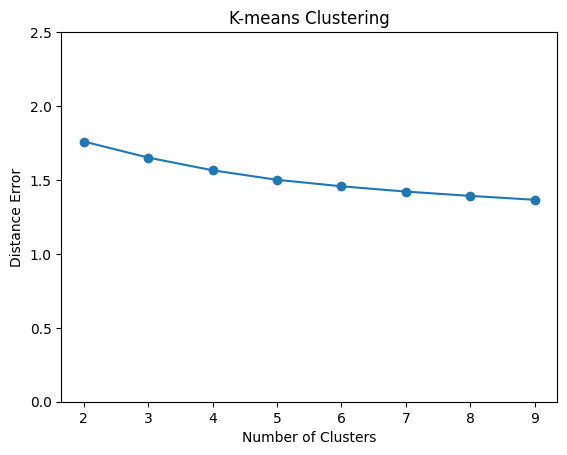

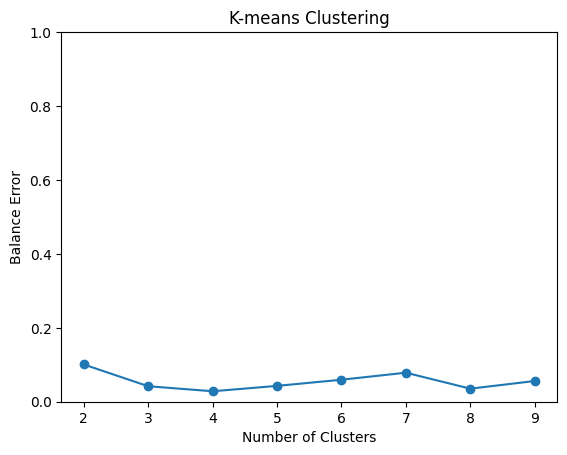

In [9]:
## Plot errors and pick how many cluster

# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,10))

# collect distance, likelihood and balance errors
dist_err = []
like_err = []
bala_err = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeansClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  dist_err.append(mm.distance_error())
  bala_err.append(mm.balance_error())

# plot errors as function of number of clusters
plt.plot(num_clusters, dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("K-means Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

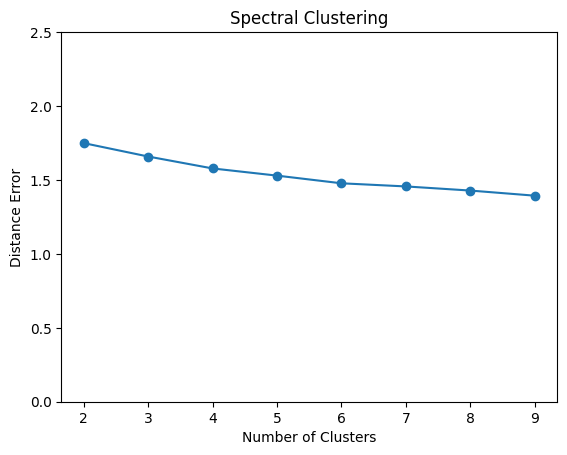

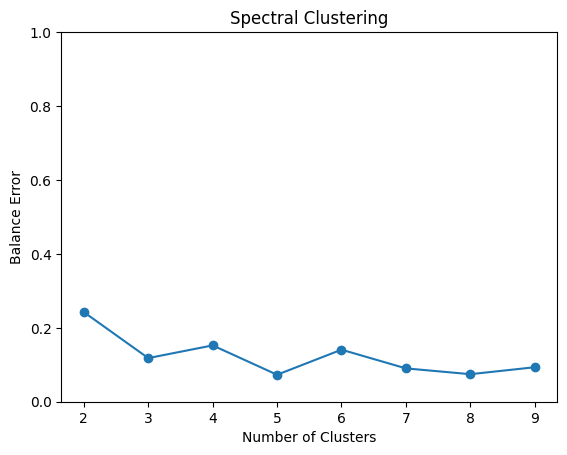

In [10]:
# try 2 - 10 clusters for Spectral Clustering
num_clusters = list(range(2,10))

# collect distance, likelihood and balance errors
dist_err = []
like_err = []
bala_err = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = SpectralClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  dist_err.append(mm.distance_error())
  bala_err.append(mm.balance_error())

# plot errors as function of number of clusters
plt.plot(num_clusters, dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?
</span>

Yes, the distance error decreases gradually as the number of clusters increases, but the rate of improvement slows down around 5 to 6 clusters.

Using 5 clusters seems to provide a good balance, as the distance error is relatively low, and the balance error is also stable and minimal according to both methods.

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

KMeans distance error: 1.5005822401213371
KMeans likelihood error: -5.303193803993659
KMeans balance error: 0.04553571428571428


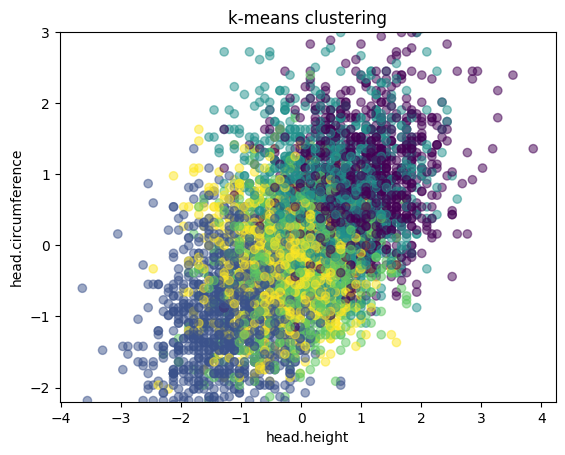

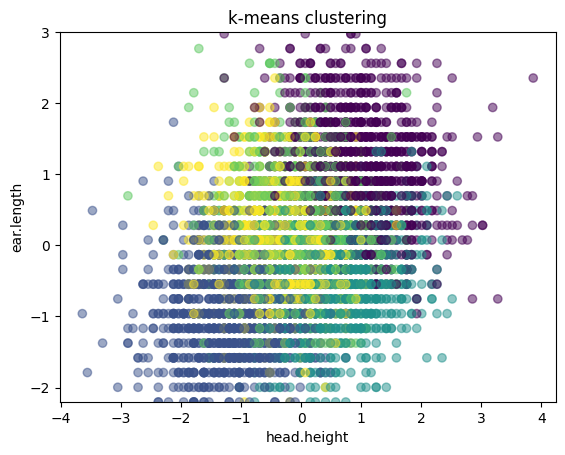

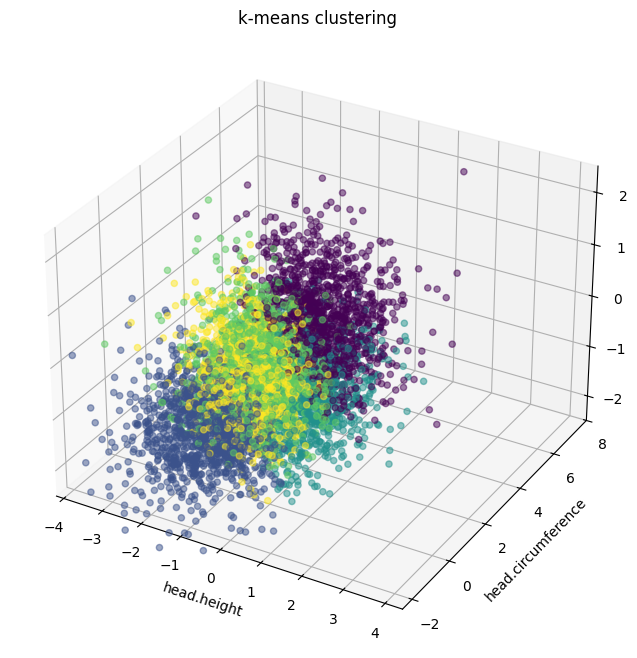

In [11]:
## Re-run clustering with final number of clusters
n_clusters = 5
km_model = KMeansClustering(n_clusters=n_clusters)

## Run the model on the training data
km_predicted = km_model.fit_predict(ansur_features)

## Check errors
print("KMeans distance error:", km_model.distance_error())
print("KMeans likelihood error:", km_model.likelihood_error())
print("KMeans balance error:", km_model.balance_error())

## Plot in 3D
xl, yl, zl = "head.height", "head.circumference", "ear.length"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

clusters = km_predicted["clusters"]

# 2D
plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)
ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.show()


Spectral distance error: 1.5293599572058512
Spectral likelihood error: -5.341446689480842
Spectral balance error: 0.07299107142857142


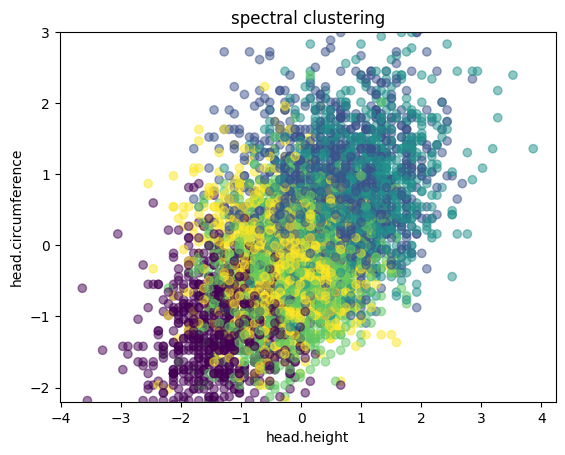

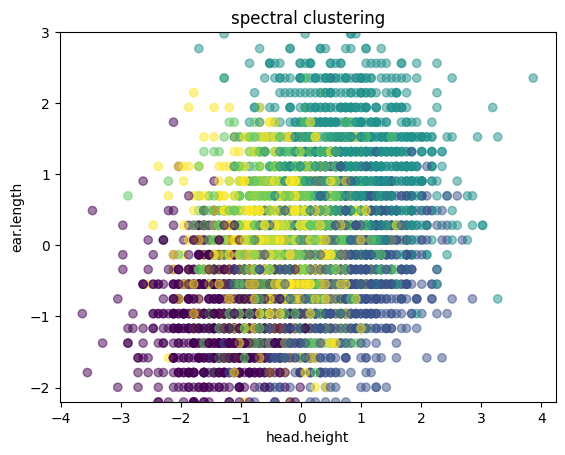

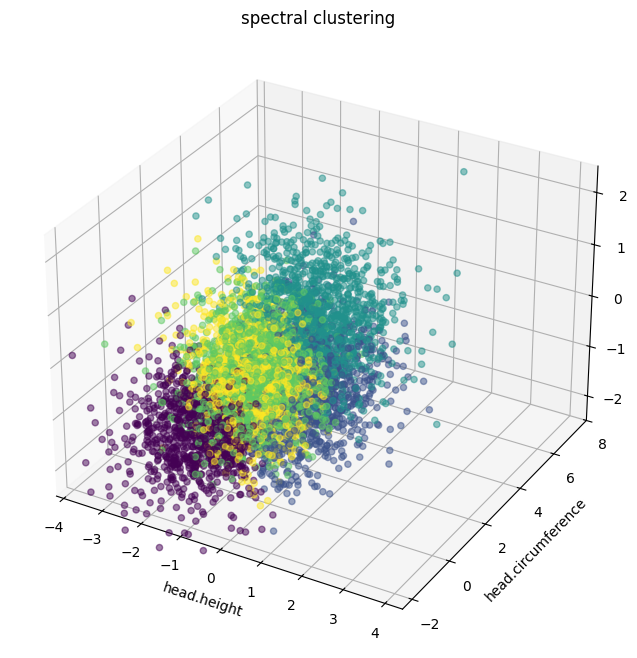

In [12]:
n_clusters = 5
sc_model = SpectralClustering(n_clusters=n_clusters)

sc_predicted = sc_model.fit_predict(ansur_features)

print("Spectral distance error:", sc_model.distance_error())
print("Spectral likelihood error:", sc_model.likelihood_error())
print("Spectral balance error:", sc_model.balance_error())

sc_clusters = sc_predicted["clusters"]

xl, yl, zl = "head.height", "head.circumference", "ear.length"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

# 2D
plt.scatter(x, y, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("spectral clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.show()

### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?
</span>

The data points are slightly more evenly distributed across clusters, but still not very defined. 

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same as last week. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [13]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

In [14]:
# TODO: check and see what is inside the list here
print(train_files[0:3])

['28-64.jpg', '31-05.jpg', '08-53.jpg']


Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [15]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [16]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(pixel_data[0])
print(label_data[0:3])

[99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 101, 101, 102, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 103, 104, 104, 104, 104, 103, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 106, 106, 107, 107, 107, 105, 106, 106, 107, 107, 108, 108, 108, 110, 110, 110, 109, 109, 108, 108, 108, 109, 109, 109, 110, 111, 111, 111, 112, 110, 107, 108, 112, 113, 112, 114, 118, 115, 118, 109, 108, 119, 112, 106, 117, 117, 117, 116, 116, 115, 114, 114, 114, 113, 113, 113, 113, 113, 113, 113, 113, 116, 116, 115, 114, 114, 114, 115, 115, 117, 117, 117, 118, 119, 120, 120, 121, 122, 122, 122, 121, 121, 121, 121, 121, 120, 120, 120, 120, 119, 119, 119, 119, 121, 121, 122, 122, 122, 122, 122, 122, 122, 123, 123, 122, 120, 119, 121, 123, 145, 159, 167, 162, 161, 165, 164, 157, 157, 151, 145, 144, 146, 145, 138, 131, 132, 134, 135, 133, 128, 125, 125, 125, 130, 116, 115, 121, 118, 119, 123, 120, 119, 119, 

Like last week, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

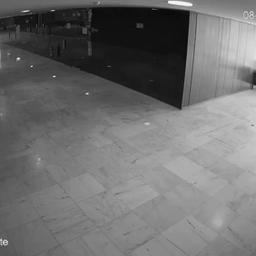

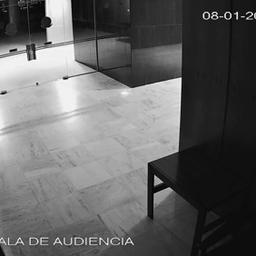

In [17]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did last week with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `HW08`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [18]:
# TODO: run PCA, get DataFrame
pca = PCA(n_components=10)
cam_pca_df = pca.fit_transform(pixel_data)

# TODO: add "label" column
cam_pca_df["label"] = label_data

# TODO: print variance
print(pca.explained_variance())

# TODO: take a look at the first 5 rows
print(cam_pca_df.head())


0.7852542516325028
            PC0          PC1          PC2          PC3          PC4  \
0   3806.710420 -2697.584968  5286.902807  -732.751046 -4771.198580   
1 -10587.368383  8798.956092 -1936.086107  1612.280461  1735.170767   
2     68.211536  5796.212706  2431.049394  1465.251252 -1569.238564   
3 -10283.276623 -7454.969441  1465.377864 -2144.856963  -776.992529   
4  10706.388370  3114.193836 -2462.939756 -2917.744203  5451.233225   

           PC5          PC6          PC7          PC8          PC9  label  
0  1967.886120 -1745.560034 -2300.485516  1927.666377  -843.617951     23  
1 -1103.646167  -508.975551  2074.619535  1930.333975 -1936.897734     24  
2   349.108345  2258.225825  3556.612388 -1243.016443   942.708441      6  
3 -1890.137497  2315.707352 -1577.265453  -559.998227  -442.352739      0  
4 -3756.880469  1893.636430   265.637177  2476.909093   468.328038     15  


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

10

I also tried 1 component, 0.24 percent of variance was kept.

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

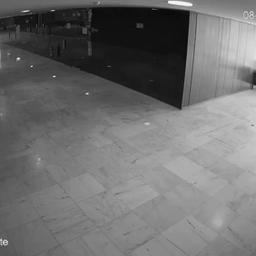

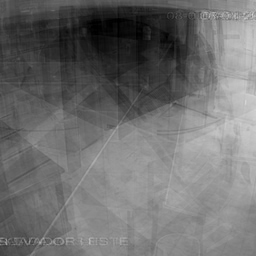

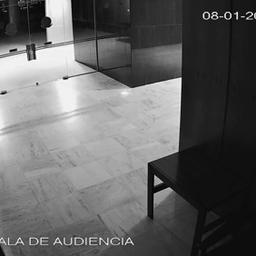

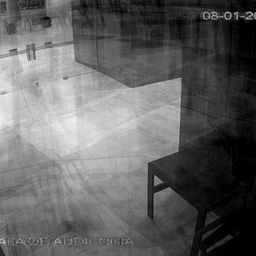

In [19]:
# TODO: reconstruct image at index 0
reconstructed = pca.inverse_transform(cam_pca_df)

display(make_image(pixel_data[0], width=256))
display(make_image(reconstructed.loc[0], width=256))

# TODO: reconstruct image at index 10
display(make_image(pixel_data[10], width=256))
display(make_image(reconstructed.loc[10], width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [20]:
# TODO: create a classifier
cam_model = RandomForestClassifier()

# TODO: split input and output features
X = cam_pca_df.drop("label", axis=1)
y = cam_pca_df["label"]

# TODO: fit the model
cam_model.fit(X, y)

# TODO: run predictions
train_predictions = cam_model.predict(X)


### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [21]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

The model achieved an accuracy of 1.0, meaning it perfectly predicted all test labels. This suggests that the classifier worked very effectively with the chosen features and the test data distribution.

We shouldn't expect the same result from the test dataset because the model was trained using the train files. While the perfect accuracy indicates a strong model, the result might not generalize to unseen real-world data due to potential overfitting or a lack of diversity in the dataset.

### Run on Test set

Now we'll open the image files inside the `./data/images/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [22]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test") if f.endswith(".jpg")]
# TODO: check its length and content
print(len(test_files))
print(test_files[0:3])

1573
['15709132.jpg', '12405239.jpg', '10894318.jpg']


We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [23]:
test_pixel_data = []

for fname in test_files:
  img = open_image(path.join("./data/images/0801-500/test", fname))
  test_pixel_data.append(img.pixels)

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [24]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one

test_pca_data = pca.transform(test_pixel_data)
test_pca_df = pd.DataFrame(test_pca_data)


It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

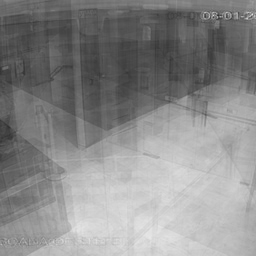

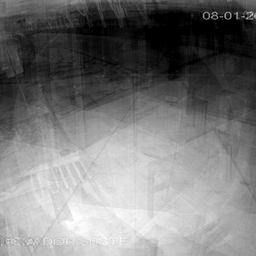

            PC0           PC1           PC2          PC3          PC4  \
0  10756.270379    -80.397187   2766.832441  1225.312046  1468.944215   
1  13404.140244  -7054.936601  -5451.250815 -1001.524891   972.399216   
2   7842.585261  -6936.565261   3573.030862 -3847.971440 -2020.064306   
3   6199.413679   3318.375679 -13466.048300 -3065.248991 -3172.224881   
4  -8031.523793 -16438.196109  -3035.505924  3891.619320  3036.934180   

           PC5          PC6          PC7          PC8          PC9  
0   109.006997 -3006.405269  1898.304348   -64.257208  -741.341140  
1   287.049976  -979.920660 -1271.729929 -1206.290047  2352.314331  
2   345.015049 -3191.618248  5558.752566  1344.410398 -3737.445634  
3  2329.323700 -1747.085856 -1934.458397   202.756214 -2645.261503  
4 -1067.608539  3196.034114  -783.350102  2479.092931   759.746843  


In [25]:
# TODO: reconstruct one or two images
reconstructed_test = pca.inverse_transform(test_pca_df)

display(make_image(reconstructed_test.loc[0], width=256))
display(make_image(reconstructed_test.loc[1], width=256))

# TODO: take a look at the first 5 rows
print(test_pca_df.head())

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

The reconstructed images from the test set are noisier because PCA reduces the dimensionality of the data, preserving only the most significant components. This process inevitably discards some less prominent features, causing a loss of fine details.



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [26]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
test_predictions = cam_model.predict(test_pca_df)

# TODO: get accuracy
test_accuracy = CamUtils.classification_accuracy(test_files, test_predictions)
print(test_accuracy)

0.9230769230769231


### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to last week's classification model? They can both be tuned to perform well, but how many features did we need last week to get an accuracy comparable to this?
</span>

The accuracy on the test set is 92.05%, which indicates that the model correctly predicted the labels for a significant majority of the test images. This shows that the model is performing well but not perfectly.

We could further improve the model with retaining more components in PCA to see if additional features can help capture subtle variations in the images.

The accuracy of 92.05% is better than last week’s model. Last week's model also needed at least 100 features to perform relatively well. 